**GAN ile Yapay Zekaya Resim Oluşturtmak**

Öncelikle "Opendatasets" ismi verilen, internetteki açık verisetlerini indirmeye yarayan modül indirilir.

In [ ]:
!pip install opendatasets --upgrade --quiet

Yapay zekanın üretilmesinde gerekli olan kütüphaneler aktarılır.

In [ ]:
import opendatasets as od
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.datasets as dset
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from IPython.display import Image, display

Dataset linki aktarılır. Tek klasörden oluşan datasetleri bu şekilde indirmeye gerek kalmadan kullanılabilir.

Fakat datasetinin manuel olarak indirilerek bir klasörün içerisine aktarılması, istisnasız tüm datasetlerinin kullanımına olanak tanır.

In [ ]:
dataset_link = 'https://www.kaggle.com/datasets/danielvalyano/abstract-paintings'
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: omurdinek
Your Kaggle Key: ··········


100%|██████████| 443M/443M [00:19<00:00, 23.5MB/s]


Colab'e gömülü olan gereksiz dosyalar silinir.

In [ ]:
rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
DATA_DIR = './abstract-paintings'
# eger link kullanılacaksa, DATA_DIR = './chinese-landscape-painting-dataset' şeklinde belirlenir.
print(os.listdir(DATA_DIR))

['img']


Resim boyutları ve yapay zekaya öğretilecek veri paketi boyutu verilir.

In [ ]:
resim_boyutu = 64
veri_paketi_boyutu = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

Yapay zekaya öğretilecek veriseti ön işlemeden geçirilir.

In [ ]:
egitim_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(resim_boyutu),
    T.CenterCrop(resim_boyutu),
    T.ToTensor(),
    T.Normalize(*stats)]))

egitim_dl = DataLoader(egitim_ds, veri_paketi_boyutu, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Verisetinden örnekler gösterilir.


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def resim_goster64(resimler, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(resimler.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def goster_paket64(dl, nmax=64):
    for resimler, _ in dl:
        resim_goster64(resimler, nmax)
        break

In [ ]:
def resim_goster(resimler, nmax=1):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(resimler.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def goster_paket(dl, nmax=1):
    for resimler, _ in dl:
        resim_goster(resimler, nmax)
        break

goster_paket64(egitim_dl)

Çeşitli yardımcı fonksiyonlar yazılır.

In [ ]:
def get_default_device():
    #GPU varsa seçen, yoksa CPU'ya geçen kod kısmı
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    #oluşturulan tensörleri aktaran kod kısmı
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #dataloader'ı wrap'leyen (toparlayan) ve veriyi cihaza aktaran kod kısmı
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        #cihaza aktarılan datayı çeken kod kısmı
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        #batch(veri paketi) sayısını döndüren kod kısmı
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
egitim_dl = DeviceDataLoader(egitim_dl, device)

**GAN Discriminator Kısmı:**

In [ ]:
discriminator = nn.Sequential(
    # input: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),                                      #deconvolutional kullandık. unpooling yaparak büyüttük.
    # output: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # output: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # output: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # output: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # output: 1 x 1 x 1
    # sonuç olarak tek bir resim output olarak verilir.
    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device) # discriminator kısmı cihaza gönderilir.

In [ ]:
gorunmeyen_boyutu = 128 # latent(görünmeyen veri) boyutu. Yani bizim kullanacağımız resim verilerinin görünmeyen, gizli bir temsili.

**GAN Generator Kısmı:**

In [ ]:
generator = nn.Sequential(
    # input: gorunmeyen_boyutu x 1 x 1

    nn.ConvTranspose2d(gorunmeyen_boyutu, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # output: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False), #convolutional kullandık. pooling yaparak küçülttük.
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # output: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # output: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # output: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # output: 3 x 64 x 64
)

In [ ]:
xb = torch.randn(veri_paketi_boyutu, gorunmeyen_boyutu, 1, 1) # rastgele latent tensörleri  x değişkeninde depolanır
fake_resimler = generator(xb)
print(fake_resimler.shape)

torch.Size([128, 3, 64, 64])


In [ ]:
generator = to_device(generator, device) # generator kısmı cihaza gönderilir.

**Discriminator'un Eğitim Kısmı:**

In [ ]:
def egit_discriminator(gercek_resimler, opt_d):
    # Öncelikle discriminator'un gradyanları temizlenir.
    opt_d.zero_grad()

    # Eğitim görselleri discriminator'den geçirilir.
    gercek_tahminler = discriminator(gercek_resimler)
    gercek_hedefler = torch.ones(gercek_resimler.size(0), 1, device=device)
    gercek_kayip = F.binary_cross_entropy(gercek_tahminler, gercek_hedefler)
    gercek_skor = torch.mean(gercek_tahminler).item()

    # generator'e latent aktarılarak, fake resimler üretmesi sağlanır.
    gorunmeyen = torch.randn(veri_paketi_boyutu, gorunmeyen_boyutu, 1, 1, device=device)
    fake_resimler = generator(gorunmeyen)

    # Fake resimler, discriminator'den geçirilir.
    fake_targets = torch.zeros(fake_resimler.size(0), 1, device=device)
    fake_tahminler = discriminator(fake_resimler)
    fake_kayip = F.binary_cross_entropy(fake_tahminler, fake_targets)
    fake_skor = torch.mean(fake_tahminler).item()

    # Discriminator ağırlıkları güncellenir.
    loss = gercek_kayip + fake_kayip
    loss.backward()
    opt_d.step()
    return loss.item(), gercek_skor, fake_skor

**Generator'un Eğitim Kısmı:**

In [ ]:
def egit_generator(opt_g):
    # Öncelikle generator'un gradyanları temizlenir.
    opt_g.zero_grad()

    # Fake resimler üretilir.
    gorunmeyen = torch.randn(veri_paketi_boyutu, gorunmeyen_boyutu, 1, 1, device=device)
    fake_resimler = generator(gorunmeyen)

    # Discriminator kandırılmaya çalışılır.
    tahminler = discriminator(fake_resimler)
    hedefler = torch.ones(veri_paketi_boyutu, 1, device=device)
    kayip = F.binary_cross_entropy(tahminler, hedefler)

    # Generator ağırlıkları güncellenir.
    kayip.backward()
    opt_g.step()

    return kayip.item()

Kaydedilecek resimlerin ismi belirlenir.

In [ ]:
ornek_dosya = 'uretilen'
os.makedirs(ornek_dosya, exist_ok=True)

In [ ]:
def ornekleri_kaydet64(index, gorunmeyen_tensorleri, show=True):
    fake_resimler = generator(gorunmeyen_tensorleri)
    fake_dosya_ismi = 'uretilen-resimler64-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_resimler), os.path.join(ornek_dosya, fake_dosya_ismi), nrow=8) # save_image, resimleri kaydetmeye yarayan built-in bir fonksiyondur.
    print('Saving', fake_dosya_ismi)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_resimler.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
def ornekleri_kaydet(index, gorunmeyen_tensorleri, show=True):
    fake_resimler = generator(gorunmeyen_tensorleri)
    fake_dosya_ismi = 'uretilen-resimler-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_resimler), os.path.join(ornek_dosya, fake_dosya_ismi), nrow=1) # save_image, resimleri kaydetmeye yarayan built-in bir fonksiyondur.
    print('Saving', fake_dosya_ismi)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_resimler.cpu().detach(), nrow=1).permute(1, 2, 0))

In [ ]:
son_gorunmeyen64 = torch.randn(64, gorunmeyen_boyutu, 1, 1, device=device)
# ornekleri_kaydet64(0, son_gorunmeyen64)

In [ ]:
son_gorunmeyen = torch.randn(1, gorunmeyen_boyutu, 1, 1, device=device)
# ornekleri_kaydet(0, son_gorunmeyen)

**Modeli Fit Etme Kısmı:**

In [ ]:
def fit(caglar, ogrenme_orani , start_idx=1):
    torch.cuda.empty_cache()

    # kayıp değerleri ve skorlar:
    kayiplar_g = []
    kayiplar_d = []
    gercek_skorlar = []
    fake_skorlar = []

    # optimize ediciler belirlendi.
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=ogrenme_orani, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=ogrenme_orani, betas=(0.5, 0.999))

    for cag in range(caglar):
        for gercek_resimler, _ in tqdm(egitim_dl):
            # discriminator eğitildi.
            kayip_d, gercek_skor, fake_skor = egit_discriminator(gercek_resimler, opt_d)
            # generator eğitildi.
            kayip_g = egit_generator(opt_g)

        # Kayıp değerleri ve skorlar kaydedildi.
        kayiplar_g.append(kayip_g)
        kayiplar_d.append(kayip_d)
        gercek_skorlar.append(gercek_skor)
        fake_skorlar.append(fake_skor)

        # Kayıp değerleri ve skorlar girildi.
        print("Cag [{}/{}], kayip_g: {:.4f}, kayip_d: {:.4f}, gercek_skorlar: {:.4f},  fake_skorlar: {:.4f}".format(
            cag+1, caglar, kayip_g, kayip_d, gercek_skor, fake_skor))

        # Üretilen resimler kaydedildi.
        ornekleri_kaydet64(cag+start_idx, son_gorunmeyen64, show=False)
        ornekleri_kaydet(cag+start_idx, son_gorunmeyen, show=False)

    return kayiplar_g, kayiplar_d, gercek_skorlar, fake_skorlar

Öğrenme oranı(learning rate) ve çağ(epoch) belirlenmesi.

ogrenme_orani = 0.0002
caglar = 20


In [ ]:
ogrenme_orani = 0.0002
caglar = 500

In [ ]:
tarih = fit(caglar, ogrenme_orani)

  0%|          | 0/58 [00:00<?, ?it/s]

Cag [1/200], kayip_g: 4.5372, kayip_d: 0.6170, gercek_skorlar: 0.6055,  fake_skorlar: 0.0395
Saving uretilen-resimler64-0001.png
Saving uretilen-resimler-0001.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [2/200], kayip_g: 8.3402, kayip_d: 2.1231, gercek_skorlar: 0.9205,  fake_skorlar: 0.8493
Saving uretilen-resimler64-0002.png
Saving uretilen-resimler-0002.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [3/200], kayip_g: 3.2454, kayip_d: 0.6960, gercek_skorlar: 0.7710,  fake_skorlar: 0.3243
Saving uretilen-resimler64-0003.png
Saving uretilen-resimler-0003.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [4/200], kayip_g: 4.3305, kayip_d: 0.5296, gercek_skorlar: 0.8783,  fake_skorlar: 0.3132
Saving uretilen-resimler64-0004.png
Saving uretilen-resimler-0004.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [5/200], kayip_g: 2.1292, kayip_d: 0.5417, gercek_skorlar: 0.6928,  fake_skorlar: 0.1271
Saving uretilen-resimler64-0005.png
Saving uretilen-resimler-0005.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [6/200], kayip_g: 3.3542, kayip_d: 0.7086, gercek_skorlar: 0.7198,  fake_skorlar: 0.2820
Saving uretilen-resimler64-0006.png
Saving uretilen-resimler-0006.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [7/200], kayip_g: 1.3147, kayip_d: 0.9801, gercek_skorlar: 0.5616,  fake_skorlar: 0.2557
Saving uretilen-resimler64-0007.png
Saving uretilen-resimler-0007.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [8/200], kayip_g: 2.6196, kayip_d: 0.7143, gercek_skorlar: 0.7210,  fake_skorlar: 0.2793
Saving uretilen-resimler64-0008.png
Saving uretilen-resimler-0008.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [9/200], kayip_g: 2.6560, kayip_d: 0.7013, gercek_skorlar: 0.6812,  fake_skorlar: 0.2231
Saving uretilen-resimler64-0009.png
Saving uretilen-resimler-0009.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [10/200], kayip_g: 2.1204, kayip_d: 0.7721, gercek_skorlar: 0.6134,  fake_skorlar: 0.1854
Saving uretilen-resimler64-0010.png
Saving uretilen-resimler-0010.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [11/200], kayip_g: 2.9372, kayip_d: 0.3428, gercek_skorlar: 0.8777,  fake_skorlar: 0.1783
Saving uretilen-resimler64-0011.png
Saving uretilen-resimler-0011.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [12/200], kayip_g: 4.1834, kayip_d: 0.5048, gercek_skorlar: 0.9495,  fake_skorlar: 0.2854
Saving uretilen-resimler64-0012.png
Saving uretilen-resimler-0012.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [13/200], kayip_g: 4.4983, kayip_d: 0.8704, gercek_skorlar: 0.7995,  fake_skorlar: 0.3953
Saving uretilen-resimler64-0013.png
Saving uretilen-resimler-0013.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [14/200], kayip_g: 5.6114, kayip_d: 0.8492, gercek_skorlar: 0.8919,  fake_skorlar: 0.4693
Saving uretilen-resimler64-0014.png
Saving uretilen-resimler-0014.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [15/200], kayip_g: 4.7971, kayip_d: 0.6453, gercek_skorlar: 0.8960,  fake_skorlar: 0.3737
Saving uretilen-resimler64-0015.png
Saving uretilen-resimler-0015.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [16/200], kayip_g: 1.4628, kayip_d: 1.2689, gercek_skorlar: 0.3641,  fake_skorlar: 0.0093
Saving uretilen-resimler64-0016.png
Saving uretilen-resimler-0016.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [17/200], kayip_g: 3.9872, kayip_d: 0.4846, gercek_skorlar: 0.8037,  fake_skorlar: 0.2003
Saving uretilen-resimler64-0017.png
Saving uretilen-resimler-0017.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [18/200], kayip_g: 2.0388, kayip_d: 0.6919, gercek_skorlar: 0.6669,  fake_skorlar: 0.1802
Saving uretilen-resimler64-0018.png
Saving uretilen-resimler-0018.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [19/200], kayip_g: 2.6986, kayip_d: 0.6951, gercek_skorlar: 0.6165,  fake_skorlar: 0.1259
Saving uretilen-resimler64-0019.png
Saving uretilen-resimler-0019.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [20/200], kayip_g: 3.9492, kayip_d: 0.5747, gercek_skorlar: 0.8669,  fake_skorlar: 0.3173
Saving uretilen-resimler64-0020.png
Saving uretilen-resimler-0020.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [21/200], kayip_g: 3.3059, kayip_d: 0.3595, gercek_skorlar: 0.7887,  fake_skorlar: 0.0927
Saving uretilen-resimler64-0021.png
Saving uretilen-resimler-0021.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [22/200], kayip_g: 1.9069, kayip_d: 0.7303, gercek_skorlar: 0.5597,  fake_skorlar: 0.0736
Saving uretilen-resimler64-0022.png
Saving uretilen-resimler-0022.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [23/200], kayip_g: 6.8520, kayip_d: 0.8725, gercek_skorlar: 0.9838,  fake_skorlar: 0.5219
Saving uretilen-resimler64-0023.png
Saving uretilen-resimler-0023.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [24/200], kayip_g: 3.6709, kayip_d: 0.5026, gercek_skorlar: 0.8305,  fake_skorlar: 0.2463
Saving uretilen-resimler64-0024.png
Saving uretilen-resimler-0024.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [25/200], kayip_g: 1.6931, kayip_d: 0.7524, gercek_skorlar: 0.5206,  fake_skorlar: 0.0153
Saving uretilen-resimler64-0025.png
Saving uretilen-resimler-0025.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [26/200], kayip_g: 2.7641, kayip_d: 0.4044, gercek_skorlar: 0.8032,  fake_skorlar: 0.1422
Saving uretilen-resimler64-0026.png
Saving uretilen-resimler-0026.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [27/200], kayip_g: 5.6642, kayip_d: 0.6483, gercek_skorlar: 0.9489,  fake_skorlar: 0.4116
Saving uretilen-resimler64-0027.png
Saving uretilen-resimler-0027.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [28/200], kayip_g: 3.9999, kayip_d: 0.4274, gercek_skorlar: 0.8639,  fake_skorlar: 0.2200
Saving uretilen-resimler64-0028.png
Saving uretilen-resimler-0028.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [29/200], kayip_g: 5.9082, kayip_d: 0.9107, gercek_skorlar: 0.9531,  fake_skorlar: 0.5236
Saving uretilen-resimler64-0029.png
Saving uretilen-resimler-0029.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [30/200], kayip_g: 4.6272, kayip_d: 0.2397, gercek_skorlar: 0.8729,  fake_skorlar: 0.0816
Saving uretilen-resimler64-0030.png
Saving uretilen-resimler-0030.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [31/200], kayip_g: 4.9554, kayip_d: 0.3436, gercek_skorlar: 0.9417,  fake_skorlar: 0.2212
Saving uretilen-resimler64-0031.png
Saving uretilen-resimler-0031.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [32/200], kayip_g: 5.9434, kayip_d: 0.8246, gercek_skorlar: 0.9529,  fake_skorlar: 0.4783
Saving uretilen-resimler64-0032.png
Saving uretilen-resimler-0032.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [33/200], kayip_g: 4.2433, kayip_d: 0.2539, gercek_skorlar: 0.9306,  fake_skorlar: 0.1530
Saving uretilen-resimler64-0033.png
Saving uretilen-resimler-0033.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [34/200], kayip_g: 7.0278, kayip_d: 0.7536, gercek_skorlar: 0.9908,  fake_skorlar: 0.4761
Saving uretilen-resimler64-0034.png
Saving uretilen-resimler-0034.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [35/200], kayip_g: 4.0564, kayip_d: 0.2710, gercek_skorlar: 0.8831,  fake_skorlar: 0.1248
Saving uretilen-resimler64-0035.png
Saving uretilen-resimler-0035.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [36/200], kayip_g: 2.3324, kayip_d: 0.3021, gercek_skorlar: 0.8351,  fake_skorlar: 0.0964
Saving uretilen-resimler64-0036.png
Saving uretilen-resimler-0036.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [37/200], kayip_g: 5.0655, kayip_d: 0.5600, gercek_skorlar: 0.9410,  fake_skorlar: 0.3545
Saving uretilen-resimler64-0037.png
Saving uretilen-resimler-0037.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [38/200], kayip_g: 2.7004, kayip_d: 0.3200, gercek_skorlar: 0.8454,  fake_skorlar: 0.1198
Saving uretilen-resimler64-0038.png
Saving uretilen-resimler-0038.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [39/200], kayip_g: 3.3620, kayip_d: 0.2891, gercek_skorlar: 0.9000,  fake_skorlar: 0.1494
Saving uretilen-resimler64-0039.png
Saving uretilen-resimler-0039.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [40/200], kayip_g: 0.4898, kayip_d: 0.8938, gercek_skorlar: 0.4885,  fake_skorlar: 0.0492
Saving uretilen-resimler64-0040.png
Saving uretilen-resimler-0040.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [41/200], kayip_g: 4.4029, kayip_d: 0.3028, gercek_skorlar: 0.8631,  fake_skorlar: 0.1243
Saving uretilen-resimler64-0041.png
Saving uretilen-resimler-0041.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [42/200], kayip_g: 4.6597, kayip_d: 0.2246, gercek_skorlar: 0.9655,  fake_skorlar: 0.1632
Saving uretilen-resimler64-0042.png
Saving uretilen-resimler-0042.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [43/200], kayip_g: 6.5922, kayip_d: 1.0910, gercek_skorlar: 0.9591,  fake_skorlar: 0.6077
Saving uretilen-resimler64-0043.png
Saving uretilen-resimler-0043.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [44/200], kayip_g: 7.8977, kayip_d: 1.2893, gercek_skorlar: 0.9901,  fake_skorlar: 0.6577
Saving uretilen-resimler64-0044.png
Saving uretilen-resimler-0044.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [45/200], kayip_g: 4.0925, kayip_d: 0.3172, gercek_skorlar: 0.8642,  fake_skorlar: 0.1415
Saving uretilen-resimler64-0045.png
Saving uretilen-resimler-0045.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [46/200], kayip_g: 3.7953, kayip_d: 0.2267, gercek_skorlar: 0.8648,  fake_skorlar: 0.0677
Saving uretilen-resimler64-0046.png
Saving uretilen-resimler-0046.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [47/200], kayip_g: 2.7072, kayip_d: 0.2040, gercek_skorlar: 0.9096,  fake_skorlar: 0.0946
Saving uretilen-resimler64-0047.png
Saving uretilen-resimler-0047.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [48/200], kayip_g: 3.3282, kayip_d: 0.2697, gercek_skorlar: 0.8088,  fake_skorlar: 0.0356
Saving uretilen-resimler64-0048.png
Saving uretilen-resimler-0048.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [49/200], kayip_g: 1.2531, kayip_d: 0.4337, gercek_skorlar: 0.7281,  fake_skorlar: 0.0691
Saving uretilen-resimler64-0049.png
Saving uretilen-resimler-0049.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [50/200], kayip_g: 5.3193, kayip_d: 0.2506, gercek_skorlar: 0.9460,  fake_skorlar: 0.1640
Saving uretilen-resimler64-0050.png
Saving uretilen-resimler-0050.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [51/200], kayip_g: 7.6625, kayip_d: 0.8619, gercek_skorlar: 0.8887,  fake_skorlar: 0.4699
Saving uretilen-resimler64-0051.png
Saving uretilen-resimler-0051.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [52/200], kayip_g: 1.2257, kayip_d: 0.6886, gercek_skorlar: 0.6124,  fake_skorlar: 0.0986
Saving uretilen-resimler64-0052.png
Saving uretilen-resimler-0052.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [53/200], kayip_g: 4.5288, kayip_d: 0.4345, gercek_skorlar: 0.9467,  fake_skorlar: 0.2848
Saving uretilen-resimler64-0053.png
Saving uretilen-resimler-0053.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [54/200], kayip_g: 5.4621, kayip_d: 0.3288, gercek_skorlar: 0.9700,  fake_skorlar: 0.2401
Saving uretilen-resimler64-0054.png
Saving uretilen-resimler-0054.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [55/200], kayip_g: 3.5824, kayip_d: 0.3572, gercek_skorlar: 0.8665,  fake_skorlar: 0.1760
Saving uretilen-resimler64-0055.png
Saving uretilen-resimler-0055.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [56/200], kayip_g: 6.0294, kayip_d: 0.6700, gercek_skorlar: 0.9896,  fake_skorlar: 0.4438
Saving uretilen-resimler64-0056.png
Saving uretilen-resimler-0056.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [57/200], kayip_g: 3.5892, kayip_d: 0.3738, gercek_skorlar: 0.7392,  fake_skorlar: 0.0311
Saving uretilen-resimler64-0057.png
Saving uretilen-resimler-0057.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [58/200], kayip_g: 4.9722, kayip_d: 0.3854, gercek_skorlar: 0.9804,  fake_skorlar: 0.2758
Saving uretilen-resimler64-0058.png
Saving uretilen-resimler-0058.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [59/200], kayip_g: 2.7160, kayip_d: 0.1526, gercek_skorlar: 0.9125,  fake_skorlar: 0.0524
Saving uretilen-resimler64-0059.png
Saving uretilen-resimler-0059.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [60/200], kayip_g: 1.2199, kayip_d: 0.5900, gercek_skorlar: 0.6160,  fake_skorlar: 0.0306
Saving uretilen-resimler64-0060.png
Saving uretilen-resimler-0060.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [61/200], kayip_g: 4.0834, kayip_d: 0.1970, gercek_skorlar: 0.9383,  fake_skorlar: 0.1166
Saving uretilen-resimler64-0061.png
Saving uretilen-resimler-0061.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [62/200], kayip_g: 4.6762, kayip_d: 0.1357, gercek_skorlar: 0.9671,  fake_skorlar: 0.0916
Saving uretilen-resimler64-0062.png
Saving uretilen-resimler-0062.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [63/200], kayip_g: 5.9917, kayip_d: 0.5193, gercek_skorlar: 0.6538,  fake_skorlar: 0.0030
Saving uretilen-resimler64-0063.png
Saving uretilen-resimler-0063.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [64/200], kayip_g: 5.2708, kayip_d: 0.0862, gercek_skorlar: 0.9754,  fake_skorlar: 0.0572
Saving uretilen-resimler64-0064.png
Saving uretilen-resimler-0064.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [65/200], kayip_g: 3.8019, kayip_d: 0.3077, gercek_skorlar: 0.8182,  fake_skorlar: 0.0794
Saving uretilen-resimler64-0065.png
Saving uretilen-resimler-0065.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [66/200], kayip_g: 4.2350, kayip_d: 0.2636, gercek_skorlar: 0.9713,  fake_skorlar: 0.1846
Saving uretilen-resimler64-0066.png
Saving uretilen-resimler-0066.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [67/200], kayip_g: 3.6491, kayip_d: 0.4609, gercek_skorlar: 0.9897,  fake_skorlar: 0.3175
Saving uretilen-resimler64-0067.png
Saving uretilen-resimler-0067.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [68/200], kayip_g: 3.5228, kayip_d: 0.4545, gercek_skorlar: 0.6785,  fake_skorlar: 0.0139
Saving uretilen-resimler64-0068.png
Saving uretilen-resimler-0068.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [69/200], kayip_g: 4.7616, kayip_d: 0.0761, gercek_skorlar: 0.9539,  fake_skorlar: 0.0263
Saving uretilen-resimler64-0069.png
Saving uretilen-resimler-0069.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [70/200], kayip_g: 3.8862, kayip_d: 0.1729, gercek_skorlar: 0.9014,  fake_skorlar: 0.0592
Saving uretilen-resimler64-0070.png
Saving uretilen-resimler-0070.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [71/200], kayip_g: 3.4380, kayip_d: 0.2825, gercek_skorlar: 0.8976,  fake_skorlar: 0.1439
Saving uretilen-resimler64-0071.png
Saving uretilen-resimler-0071.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [72/200], kayip_g: 4.8882, kayip_d: 0.1749, gercek_skorlar: 0.9816,  fake_skorlar: 0.1358
Saving uretilen-resimler64-0072.png
Saving uretilen-resimler-0072.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [73/200], kayip_g: 4.2042, kayip_d: 0.1484, gercek_skorlar: 0.8987,  fake_skorlar: 0.0338
Saving uretilen-resimler64-0073.png
Saving uretilen-resimler-0073.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [74/200], kayip_g: 3.7129, kayip_d: 0.1412, gercek_skorlar: 0.8978,  fake_skorlar: 0.0279
Saving uretilen-resimler64-0074.png
Saving uretilen-resimler-0074.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [75/200], kayip_g: 4.5261, kayip_d: 0.1913, gercek_skorlar: 0.8457,  fake_skorlar: 0.0107
Saving uretilen-resimler64-0075.png
Saving uretilen-resimler-0075.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [76/200], kayip_g: 2.3235, kayip_d: 0.3339, gercek_skorlar: 0.7545,  fake_skorlar: 0.0092
Saving uretilen-resimler64-0076.png
Saving uretilen-resimler-0076.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [77/200], kayip_g: 4.2807, kayip_d: 0.1183, gercek_skorlar: 0.9536,  fake_skorlar: 0.0653
Saving uretilen-resimler64-0077.png
Saving uretilen-resimler-0077.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [78/200], kayip_g: 3.9557, kayip_d: 0.2492, gercek_skorlar: 0.8285,  fake_skorlar: 0.0226
Saving uretilen-resimler64-0078.png
Saving uretilen-resimler-0078.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [79/200], kayip_g: 1.6266, kayip_d: 0.3710, gercek_skorlar: 0.7418,  fake_skorlar: 0.0100
Saving uretilen-resimler64-0079.png
Saving uretilen-resimler-0079.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [80/200], kayip_g: 4.5309, kayip_d: 0.2391, gercek_skorlar: 0.9851,  fake_skorlar: 0.1853
Saving uretilen-resimler64-0080.png
Saving uretilen-resimler-0080.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [81/200], kayip_g: 3.2612, kayip_d: 0.3204, gercek_skorlar: 0.8069,  fake_skorlar: 0.0759
Saving uretilen-resimler64-0081.png
Saving uretilen-resimler-0081.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [82/200], kayip_g: 2.5956, kayip_d: 0.4096, gercek_skorlar: 0.7383,  fake_skorlar: 0.0230
Saving uretilen-resimler64-0082.png
Saving uretilen-resimler-0082.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [83/200], kayip_g: 4.1036, kayip_d: 0.3453, gercek_skorlar: 0.9646,  fake_skorlar: 0.2263
Saving uretilen-resimler64-0083.png
Saving uretilen-resimler-0083.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [84/200], kayip_g: 2.7124, kayip_d: 0.1692, gercek_skorlar: 0.8832,  fake_skorlar: 0.0338
Saving uretilen-resimler64-0084.png
Saving uretilen-resimler-0084.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [85/200], kayip_g: 3.1755, kayip_d: 0.0806, gercek_skorlar: 0.9778,  fake_skorlar: 0.0546
Saving uretilen-resimler64-0085.png
Saving uretilen-resimler-0085.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [86/200], kayip_g: 6.2008, kayip_d: 0.7543, gercek_skorlar: 0.9904,  fake_skorlar: 0.4590
Saving uretilen-resimler64-0086.png
Saving uretilen-resimler-0086.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [87/200], kayip_g: 5.8008, kayip_d: 0.3692, gercek_skorlar: 0.9572,  fake_skorlar: 0.2532
Saving uretilen-resimler64-0087.png
Saving uretilen-resimler-0087.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [88/200], kayip_g: 5.8288, kayip_d: 0.5628, gercek_skorlar: 0.9977,  fake_skorlar: 0.3880
Saving uretilen-resimler64-0088.png
Saving uretilen-resimler-0088.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [89/200], kayip_g: 1.0225, kayip_d: 0.5612, gercek_skorlar: 0.6321,  fake_skorlar: 0.0335
Saving uretilen-resimler64-0089.png
Saving uretilen-resimler-0089.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [90/200], kayip_g: 3.4753, kayip_d: 0.1324, gercek_skorlar: 0.9957,  fake_skorlar: 0.1133
Saving uretilen-resimler64-0090.png
Saving uretilen-resimler-0090.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [91/200], kayip_g: 3.8045, kayip_d: 0.0812, gercek_skorlar: 0.9531,  fake_skorlar: 0.0306
Saving uretilen-resimler64-0091.png
Saving uretilen-resimler-0091.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [92/200], kayip_g: 3.9555, kayip_d: 0.0830, gercek_skorlar: 0.9337,  fake_skorlar: 0.0073
Saving uretilen-resimler64-0092.png
Saving uretilen-resimler-0092.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [93/200], kayip_g: 4.7930, kayip_d: 0.1303, gercek_skorlar: 0.9218,  fake_skorlar: 0.0431
Saving uretilen-resimler64-0093.png
Saving uretilen-resimler-0093.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [94/200], kayip_g: 1.7143, kayip_d: 0.2293, gercek_skorlar: 0.8348,  fake_skorlar: 0.0342
Saving uretilen-resimler64-0094.png
Saving uretilen-resimler-0094.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [95/200], kayip_g: 3.6731, kayip_d: 0.1522, gercek_skorlar: 0.9390,  fake_skorlar: 0.0776
Saving uretilen-resimler64-0095.png
Saving uretilen-resimler-0095.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [96/200], kayip_g: 3.9000, kayip_d: 0.1370, gercek_skorlar: 0.9770,  fake_skorlar: 0.0993
Saving uretilen-resimler64-0096.png
Saving uretilen-resimler-0096.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [97/200], kayip_g: 2.8893, kayip_d: 0.3631, gercek_skorlar: 0.8375,  fake_skorlar: 0.1331
Saving uretilen-resimler64-0097.png
Saving uretilen-resimler-0097.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [98/200], kayip_g: 5.3152, kayip_d: 0.1077, gercek_skorlar: 0.9722,  fake_skorlar: 0.0693
Saving uretilen-resimler64-0098.png
Saving uretilen-resimler-0098.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [99/200], kayip_g: 1.0117, kayip_d: 0.8539, gercek_skorlar: 0.5528,  fake_skorlar: 0.1368
Saving uretilen-resimler64-0099.png
Saving uretilen-resimler-0099.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [100/200], kayip_g: 2.8909, kayip_d: 0.1615, gercek_skorlar: 0.8869,  fake_skorlar: 0.0348
Saving uretilen-resimler64-0100.png
Saving uretilen-resimler-0100.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [101/200], kayip_g: 4.1968, kayip_d: 0.0996, gercek_skorlar: 0.9234,  fake_skorlar: 0.0173
Saving uretilen-resimler64-0101.png
Saving uretilen-resimler-0101.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [102/200], kayip_g: 3.2307, kayip_d: 0.2240, gercek_skorlar: 0.8893,  fake_skorlar: 0.0918
Saving uretilen-resimler64-0102.png
Saving uretilen-resimler-0102.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [103/200], kayip_g: 4.4065, kayip_d: 0.0719, gercek_skorlar: 0.9891,  fake_skorlar: 0.0571
Saving uretilen-resimler64-0103.png
Saving uretilen-resimler-0103.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [104/200], kayip_g: 5.7792, kayip_d: 0.6290, gercek_skorlar: 0.9633,  fake_skorlar: 0.3918
Saving uretilen-resimler64-0104.png
Saving uretilen-resimler-0104.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [105/200], kayip_g: 0.9289, kayip_d: 0.1048, gercek_skorlar: 0.9914,  fake_skorlar: 0.0864
Saving uretilen-resimler64-0105.png
Saving uretilen-resimler-0105.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [106/200], kayip_g: 3.7566, kayip_d: 0.1202, gercek_skorlar: 0.9639,  fake_skorlar: 0.0744
Saving uretilen-resimler64-0106.png
Saving uretilen-resimler-0106.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [107/200], kayip_g: 4.9419, kayip_d: 0.0444, gercek_skorlar: 0.9861,  fake_skorlar: 0.0292
Saving uretilen-resimler64-0107.png
Saving uretilen-resimler-0107.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [108/200], kayip_g: 4.3391, kayip_d: 0.1656, gercek_skorlar: 0.9235,  fake_skorlar: 0.0753
Saving uretilen-resimler64-0108.png
Saving uretilen-resimler-0108.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [109/200], kayip_g: 10.2506, kayip_d: 1.0983, gercek_skorlar: 0.9971,  fake_skorlar: 0.5787
Saving uretilen-resimler64-0109.png
Saving uretilen-resimler-0109.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [110/200], kayip_g: 3.1875, kayip_d: 0.7851, gercek_skorlar: 0.5111,  fake_skorlar: 0.0024
Saving uretilen-resimler64-0110.png
Saving uretilen-resimler-0110.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [111/200], kayip_g: 5.4119, kayip_d: 0.1562, gercek_skorlar: 0.9889,  fake_skorlar: 0.1262
Saving uretilen-resimler64-0111.png
Saving uretilen-resimler-0111.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [112/200], kayip_g: 3.3713, kayip_d: 0.1917, gercek_skorlar: 0.8426,  fake_skorlar: 0.0102
Saving uretilen-resimler64-0112.png
Saving uretilen-resimler-0112.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [113/200], kayip_g: 4.4944, kayip_d: 0.3341, gercek_skorlar: 0.8756,  fake_skorlar: 0.1599
Saving uretilen-resimler64-0113.png
Saving uretilen-resimler-0113.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [114/200], kayip_g: 3.0612, kayip_d: 0.1311, gercek_skorlar: 0.9068,  fake_skorlar: 0.0283
Saving uretilen-resimler64-0114.png
Saving uretilen-resimler-0114.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [115/200], kayip_g: 4.1573, kayip_d: 0.2062, gercek_skorlar: 0.8422,  fake_skorlar: 0.0201
Saving uretilen-resimler64-0115.png
Saving uretilen-resimler-0115.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [116/200], kayip_g: 4.3210, kayip_d: 0.0639, gercek_skorlar: 0.9693,  fake_skorlar: 0.0312
Saving uretilen-resimler64-0116.png
Saving uretilen-resimler-0116.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [117/200], kayip_g: 4.8322, kayip_d: 0.1778, gercek_skorlar: 0.8643,  fake_skorlar: 0.0190
Saving uretilen-resimler64-0117.png
Saving uretilen-resimler-0117.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [118/200], kayip_g: 2.3365, kayip_d: 0.1527, gercek_skorlar: 0.9453,  fake_skorlar: 0.0844
Saving uretilen-resimler64-0118.png
Saving uretilen-resimler-0118.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [119/200], kayip_g: 5.7471, kayip_d: 0.2365, gercek_skorlar: 0.9382,  fake_skorlar: 0.1441
Saving uretilen-resimler64-0119.png
Saving uretilen-resimler-0119.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [120/200], kayip_g: 6.1736, kayip_d: 0.1156, gercek_skorlar: 0.9877,  fake_skorlar: 0.0935
Saving uretilen-resimler64-0120.png
Saving uretilen-resimler-0120.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [121/200], kayip_g: 3.3451, kayip_d: 0.4024, gercek_skorlar: 0.7386,  fake_skorlar: 0.0299
Saving uretilen-resimler64-0121.png
Saving uretilen-resimler-0121.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [122/200], kayip_g: 5.7510, kayip_d: 0.2189, gercek_skorlar: 0.9458,  fake_skorlar: 0.1385
Saving uretilen-resimler64-0122.png
Saving uretilen-resimler-0122.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [123/200], kayip_g: 6.0452, kayip_d: 0.4081, gercek_skorlar: 0.9745,  fake_skorlar: 0.2854
Saving uretilen-resimler64-0123.png
Saving uretilen-resimler-0123.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [124/200], kayip_g: 4.6942, kayip_d: 0.2405, gercek_skorlar: 0.9730,  fake_skorlar: 0.1677
Saving uretilen-resimler64-0124.png
Saving uretilen-resimler-0124.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [125/200], kayip_g: 4.0249, kayip_d: 0.0765, gercek_skorlar: 0.9648,  fake_skorlar: 0.0379
Saving uretilen-resimler64-0125.png
Saving uretilen-resimler-0125.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [126/200], kayip_g: 4.0256, kayip_d: 0.1452, gercek_skorlar: 0.9274,  fake_skorlar: 0.0600
Saving uretilen-resimler64-0126.png
Saving uretilen-resimler-0126.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [127/200], kayip_g: 2.9321, kayip_d: 0.2530, gercek_skorlar: 0.8809,  fake_skorlar: 0.1019
Saving uretilen-resimler64-0127.png
Saving uretilen-resimler-0127.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [128/200], kayip_g: 3.4896, kayip_d: 0.1560, gercek_skorlar: 0.9838,  fake_skorlar: 0.1122
Saving uretilen-resimler64-0128.png
Saving uretilen-resimler-0128.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [129/200], kayip_g: 4.2470, kayip_d: 0.0641, gercek_skorlar: 0.9648,  fake_skorlar: 0.0272
Saving uretilen-resimler64-0129.png
Saving uretilen-resimler-0129.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [130/200], kayip_g: 4.5065, kayip_d: 0.0844, gercek_skorlar: 0.9822,  fake_skorlar: 0.0611
Saving uretilen-resimler64-0130.png
Saving uretilen-resimler-0130.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [131/200], kayip_g: 5.1821, kayip_d: 0.0462, gercek_skorlar: 0.9602,  fake_skorlar: 0.0045
Saving uretilen-resimler64-0131.png
Saving uretilen-resimler-0131.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [132/200], kayip_g: 2.5633, kayip_d: 0.1465, gercek_skorlar: 0.9722,  fake_skorlar: 0.0866
Saving uretilen-resimler64-0132.png
Saving uretilen-resimler-0132.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [133/200], kayip_g: 4.2165, kayip_d: 0.1388, gercek_skorlar: 0.9089,  fake_skorlar: 0.0334
Saving uretilen-resimler64-0133.png
Saving uretilen-resimler-0133.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [134/200], kayip_g: 4.6496, kayip_d: 0.0613, gercek_skorlar: 0.9895,  fake_skorlar: 0.0485
Saving uretilen-resimler64-0134.png
Saving uretilen-resimler-0134.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [135/200], kayip_g: 4.9151, kayip_d: 0.1607, gercek_skorlar: 0.8712,  fake_skorlar: 0.0073
Saving uretilen-resimler64-0135.png
Saving uretilen-resimler-0135.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [136/200], kayip_g: 4.9350, kayip_d: 0.0825, gercek_skorlar: 0.9776,  fake_skorlar: 0.0546
Saving uretilen-resimler64-0136.png
Saving uretilen-resimler-0136.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [137/200], kayip_g: 4.2501, kayip_d: 0.1236, gercek_skorlar: 0.9624,  fake_skorlar: 0.0758
Saving uretilen-resimler64-0137.png
Saving uretilen-resimler-0137.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [138/200], kayip_g: 5.9023, kayip_d: 0.1655, gercek_skorlar: 0.9538,  fake_skorlar: 0.1017
Saving uretilen-resimler64-0138.png
Saving uretilen-resimler-0138.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [139/200], kayip_g: 4.0782, kayip_d: 0.0609, gercek_skorlar: 0.9810,  fake_skorlar: 0.0399
Saving uretilen-resimler64-0139.png
Saving uretilen-resimler-0139.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [140/200], kayip_g: 5.6844, kayip_d: 0.1085, gercek_skorlar: 0.9984,  fake_skorlar: 0.0929
Saving uretilen-resimler64-0140.png
Saving uretilen-resimler-0140.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [141/200], kayip_g: 5.8546, kayip_d: 0.0172, gercek_skorlar: 0.9953,  fake_skorlar: 0.0123
Saving uretilen-resimler64-0141.png
Saving uretilen-resimler-0141.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [142/200], kayip_g: 3.2462, kayip_d: 0.1391, gercek_skorlar: 0.9025,  fake_skorlar: 0.0299
Saving uretilen-resimler64-0142.png
Saving uretilen-resimler-0142.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [143/200], kayip_g: 4.2316, kayip_d: 0.2617, gercek_skorlar: 0.8476,  fake_skorlar: 0.0640
Saving uretilen-resimler64-0143.png
Saving uretilen-resimler-0143.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [144/200], kayip_g: 3.9768, kayip_d: 0.0743, gercek_skorlar: 0.9573,  fake_skorlar: 0.0282
Saving uretilen-resimler64-0144.png
Saving uretilen-resimler-0144.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [145/200], kayip_g: 1.8319, kayip_d: 0.6486, gercek_skorlar: 0.5831,  fake_skorlar: 0.0009
Saving uretilen-resimler64-0145.png
Saving uretilen-resimler-0145.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [146/200], kayip_g: 3.6898, kayip_d: 0.2399, gercek_skorlar: 0.8675,  fake_skorlar: 0.0451
Saving uretilen-resimler64-0146.png
Saving uretilen-resimler-0146.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [147/200], kayip_g: 5.0231, kayip_d: 0.0922, gercek_skorlar: 0.9640,  fake_skorlar: 0.0513
Saving uretilen-resimler64-0147.png
Saving uretilen-resimler-0147.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [148/200], kayip_g: 5.2573, kayip_d: 0.0816, gercek_skorlar: 0.9891,  fake_skorlar: 0.0653
Saving uretilen-resimler64-0148.png
Saving uretilen-resimler-0148.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [149/200], kayip_g: 4.4009, kayip_d: 0.0247, gercek_skorlar: 0.9961,  fake_skorlar: 0.0201
Saving uretilen-resimler64-0149.png
Saving uretilen-resimler-0149.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [150/200], kayip_g: 3.2735, kayip_d: 2.3413, gercek_skorlar: 0.9374,  fake_skorlar: 0.6776
Saving uretilen-resimler64-0150.png
Saving uretilen-resimler-0150.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [151/200], kayip_g: 4.7824, kayip_d: 0.2712, gercek_skorlar: 0.9966,  fake_skorlar: 0.2023
Saving uretilen-resimler64-0151.png
Saving uretilen-resimler-0151.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [152/200], kayip_g: 4.0227, kayip_d: 0.0721, gercek_skorlar: 0.9607,  fake_skorlar: 0.0297
Saving uretilen-resimler64-0152.png
Saving uretilen-resimler-0152.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [153/200], kayip_g: 4.7518, kayip_d: 0.0698, gercek_skorlar: 0.9935,  fake_skorlar: 0.0583
Saving uretilen-resimler64-0153.png
Saving uretilen-resimler-0153.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [154/200], kayip_g: 3.8526, kayip_d: 0.0657, gercek_skorlar: 0.9842,  fake_skorlar: 0.0462
Saving uretilen-resimler64-0154.png
Saving uretilen-resimler-0154.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [155/200], kayip_g: 5.1313, kayip_d: 0.0506, gercek_skorlar: 0.9772,  fake_skorlar: 0.0261
Saving uretilen-resimler64-0155.png
Saving uretilen-resimler-0155.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [156/200], kayip_g: 5.3886, kayip_d: 0.0694, gercek_skorlar: 0.9954,  fake_skorlar: 0.0608
Saving uretilen-resimler64-0156.png
Saving uretilen-resimler-0156.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [157/200], kayip_g: 5.0778, kayip_d: 0.0480, gercek_skorlar: 0.9770,  fake_skorlar: 0.0236
Saving uretilen-resimler64-0157.png
Saving uretilen-resimler-0157.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [158/200], kayip_g: 4.7638, kayip_d: 0.0459, gercek_skorlar: 0.9808,  fake_skorlar: 0.0253
Saving uretilen-resimler64-0158.png
Saving uretilen-resimler-0158.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [159/200], kayip_g: 4.9594, kayip_d: 0.0632, gercek_skorlar: 0.9733,  fake_skorlar: 0.0333
Saving uretilen-resimler64-0159.png
Saving uretilen-resimler-0159.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [160/200], kayip_g: 5.0323, kayip_d: 0.0332, gercek_skorlar: 0.9840,  fake_skorlar: 0.0166
Saving uretilen-resimler64-0160.png
Saving uretilen-resimler-0160.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [161/200], kayip_g: 4.0648, kayip_d: 0.2916, gercek_skorlar: 0.8337,  fake_skorlar: 0.0567
Saving uretilen-resimler64-0161.png
Saving uretilen-resimler-0161.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [162/200], kayip_g: 3.5907, kayip_d: 0.1774, gercek_skorlar: 0.8838,  fake_skorlar: 0.0298
Saving uretilen-resimler64-0162.png
Saving uretilen-resimler-0162.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [163/200], kayip_g: 4.3517, kayip_d: 0.1653, gercek_skorlar: 0.9965,  fake_skorlar: 0.1349
Saving uretilen-resimler64-0163.png
Saving uretilen-resimler-0163.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [164/200], kayip_g: 4.9858, kayip_d: 0.0441, gercek_skorlar: 0.9755,  fake_skorlar: 0.0187
Saving uretilen-resimler64-0164.png
Saving uretilen-resimler-0164.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [165/200], kayip_g: 2.4926, kayip_d: 3.2243, gercek_skorlar: 0.1034,  fake_skorlar: 0.0000
Saving uretilen-resimler64-0165.png
Saving uretilen-resimler-0165.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [166/200], kayip_g: 4.6065, kayip_d: 0.0737, gercek_skorlar: 0.9604,  fake_skorlar: 0.0277
Saving uretilen-resimler64-0166.png
Saving uretilen-resimler-0166.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [167/200], kayip_g: 5.3611, kayip_d: 0.1004, gercek_skorlar: 0.9354,  fake_skorlar: 0.0287
Saving uretilen-resimler64-0167.png
Saving uretilen-resimler-0167.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [168/200], kayip_g: 6.7674, kayip_d: 0.0702, gercek_skorlar: 0.9457,  fake_skorlar: 0.0128
Saving uretilen-resimler64-0168.png
Saving uretilen-resimler-0168.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [169/200], kayip_g: 5.5585, kayip_d: 0.0667, gercek_skorlar: 0.9744,  fake_skorlar: 0.0358
Saving uretilen-resimler64-0169.png
Saving uretilen-resimler-0169.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [170/200], kayip_g: 4.7910, kayip_d: 0.0237, gercek_skorlar: 0.9957,  fake_skorlar: 0.0189
Saving uretilen-resimler64-0170.png
Saving uretilen-resimler-0170.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [171/200], kayip_g: 6.1704, kayip_d: 0.1810, gercek_skorlar: 0.9929,  fake_skorlar: 0.1466
Saving uretilen-resimler64-0171.png
Saving uretilen-resimler-0171.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [172/200], kayip_g: 4.3558, kayip_d: 0.3175, gercek_skorlar: 0.7693,  fake_skorlar: 0.0068
Saving uretilen-resimler64-0172.png
Saving uretilen-resimler-0172.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [173/200], kayip_g: 4.6135, kayip_d: 0.1891, gercek_skorlar: 0.9906,  fake_skorlar: 0.1381
Saving uretilen-resimler64-0173.png
Saving uretilen-resimler-0173.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [174/200], kayip_g: 4.3172, kayip_d: 0.1175, gercek_skorlar: 0.9490,  fake_skorlar: 0.0560
Saving uretilen-resimler64-0174.png
Saving uretilen-resimler-0174.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [175/200], kayip_g: 3.8443, kayip_d: 0.1311, gercek_skorlar: 0.9396,  fake_skorlar: 0.0582
Saving uretilen-resimler64-0175.png
Saving uretilen-resimler-0175.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [176/200], kayip_g: 2.7964, kayip_d: 0.2280, gercek_skorlar: 0.8407,  fake_skorlar: 0.0318
Saving uretilen-resimler64-0176.png
Saving uretilen-resimler-0176.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [177/200], kayip_g: 3.5590, kayip_d: 0.0638, gercek_skorlar: 0.9691,  fake_skorlar: 0.0307
Saving uretilen-resimler64-0177.png
Saving uretilen-resimler-0177.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [178/200], kayip_g: 3.5708, kayip_d: 0.1765, gercek_skorlar: 0.8739,  fake_skorlar: 0.0282
Saving uretilen-resimler64-0178.png
Saving uretilen-resimler-0178.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [179/200], kayip_g: 4.3710, kayip_d: 0.0898, gercek_skorlar: 0.9321,  fake_skorlar: 0.0166
Saving uretilen-resimler64-0179.png
Saving uretilen-resimler-0179.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [180/200], kayip_g: 3.5994, kayip_d: 0.0845, gercek_skorlar: 0.9355,  fake_skorlar: 0.0112
Saving uretilen-resimler64-0180.png
Saving uretilen-resimler-0180.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [181/200], kayip_g: 2.2347, kayip_d: 0.1417, gercek_skorlar: 0.8859,  fake_skorlar: 0.0129
Saving uretilen-resimler64-0181.png
Saving uretilen-resimler-0181.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [182/200], kayip_g: 7.1291, kayip_d: 0.0598, gercek_skorlar: 0.9481,  fake_skorlar: 0.0047
Saving uretilen-resimler64-0182.png
Saving uretilen-resimler-0182.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [183/200], kayip_g: 4.0890, kayip_d: 0.1563, gercek_skorlar: 0.9887,  fake_skorlar: 0.1135
Saving uretilen-resimler64-0183.png
Saving uretilen-resimler-0183.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [184/200], kayip_g: 3.4365, kayip_d: 0.1642, gercek_skorlar: 0.9165,  fake_skorlar: 0.0657
Saving uretilen-resimler64-0184.png
Saving uretilen-resimler-0184.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [185/200], kayip_g: 4.6170, kayip_d: 0.0481, gercek_skorlar: 0.9810,  fake_skorlar: 0.0266
Saving uretilen-resimler64-0185.png
Saving uretilen-resimler-0185.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [186/200], kayip_g: 4.3385, kayip_d: 0.0080, gercek_skorlar: 0.9964,  fake_skorlar: 0.0043
Saving uretilen-resimler64-0186.png
Saving uretilen-resimler-0186.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [187/200], kayip_g: 12.3274, kayip_d: 2.8450, gercek_skorlar: 0.9978,  fake_skorlar: 0.7833
Saving uretilen-resimler64-0187.png
Saving uretilen-resimler-0187.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [188/200], kayip_g: 12.5127, kayip_d: 1.3626, gercek_skorlar: 0.9984,  fake_skorlar: 0.5937
Saving uretilen-resimler64-0188.png
Saving uretilen-resimler-0188.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [189/200], kayip_g: 5.3844, kayip_d: 0.2686, gercek_skorlar: 0.9300,  fake_skorlar: 0.1539
Saving uretilen-resimler64-0189.png
Saving uretilen-resimler-0189.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [190/200], kayip_g: 4.6669, kayip_d: 0.0516, gercek_skorlar: 0.9675,  fake_skorlar: 0.0170
Saving uretilen-resimler64-0190.png
Saving uretilen-resimler-0190.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [191/200], kayip_g: 5.4163, kayip_d: 0.5609, gercek_skorlar: 0.9983,  fake_skorlar: 0.3149
Saving uretilen-resimler64-0191.png
Saving uretilen-resimler-0191.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [192/200], kayip_g: 6.0538, kayip_d: 0.0401, gercek_skorlar: 0.9961,  fake_skorlar: 0.0346
Saving uretilen-resimler64-0192.png
Saving uretilen-resimler-0192.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [193/200], kayip_g: 4.6011, kayip_d: 0.0689, gercek_skorlar: 0.9630,  fake_skorlar: 0.0283
Saving uretilen-resimler64-0193.png
Saving uretilen-resimler-0193.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [194/200], kayip_g: 5.1660, kayip_d: 0.0491, gercek_skorlar: 0.9969,  fake_skorlar: 0.0429
Saving uretilen-resimler64-0194.png
Saving uretilen-resimler-0194.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [195/200], kayip_g: 5.7337, kayip_d: 0.2046, gercek_skorlar: 0.9409,  fake_skorlar: 0.1133
Saving uretilen-resimler64-0195.png
Saving uretilen-resimler-0195.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [196/200], kayip_g: 4.6889, kayip_d: 0.0636, gercek_skorlar: 0.9754,  fake_skorlar: 0.0322
Saving uretilen-resimler64-0196.png
Saving uretilen-resimler-0196.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [197/200], kayip_g: 6.6281, kayip_d: 0.0852, gercek_skorlar: 0.9788,  fake_skorlar: 0.0561
Saving uretilen-resimler64-0197.png
Saving uretilen-resimler-0197.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [198/200], kayip_g: 4.3054, kayip_d: 0.0353, gercek_skorlar: 0.9791,  fake_skorlar: 0.0137
Saving uretilen-resimler64-0198.png
Saving uretilen-resimler-0198.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [199/200], kayip_g: 6.2240, kayip_d: 0.0131, gercek_skorlar: 0.9960,  fake_skorlar: 0.0089
Saving uretilen-resimler64-0199.png
Saving uretilen-resimler-0199.png


  0%|          | 0/58 [00:00<?, ?it/s]

Cag [200/200], kayip_g: 6.8734, kayip_d: 0.0689, gercek_skorlar: 0.9418,  fake_skorlar: 0.0050
Saving uretilen-resimler64-0200.png
Saving uretilen-resimler-0200.png


In [ ]:
kayiplar_g, kayiplar_d, gercek_skorlar, fake_skorlar = tarih

In [ ]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

**SONUÇLARIN GÖSTERİLMESİ**

In [ ]:
print("İLK ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0001.png', width=600, height = 600))

print("ONUNCU ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0010.png', width=600, height = 600))

print("YİRMİNCİ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0020.png', width=600, height = 600))

print("KIRKINCI ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0040.png', width=600, height = 600))

print("ALTMIŞINCI ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0060.png', width=600, height = 600))

print("SEKSENİNCİ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0080.png', width=600, height = 600))

print("YÜZÜNCÜ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0100.png', width=600, height = 600))

print("YÜZELLİNCİ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0150.png', width=600, height = 600))

print("İKİYÜZÜNCÜ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0200.png', width=600, height = 600))

print("İKİYÜZÜNCÜ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0200.png', width=600, height = 600))
print("İKİYÜZÜNCÜ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler64-0200.png', width=600, height = 600))

İLK ÇAĞIN SONUCUNDA ÜRETİLEN:


NameError: ignored

İLK ÇAĞIN SONUCUNDA ÜRETİLEN:


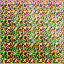

ONUNCU ÇAĞIN SONUCUNDA ÜRETİLEN:


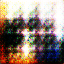

YİRMİNCİ ÇAĞIN SONUCUNDA ÜRETİLEN:


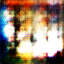

KIRKINCI ÇAĞIN SONUCUNDA ÜRETİLEN:


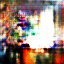

ALTMIŞINCI ÇAĞIN SONUCUNDA ÜRETİLEN:


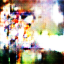

SEKSENİNCİ ÇAĞIN SONUCUNDA ÜRETİLEN:


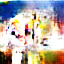

YÜZÜNCÜ ÇAĞIN SONUCUNDA ÜRETİLEN:


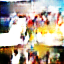

In [ ]:
print("İLK ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler-0001.png', width=600, height = 600))

print("ONUNCU ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler-0010.png', width=600, height = 600))

print("YİRMİNCİ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler-0020.png', width=600, height = 600))

print("KIRKINCI ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler-0040.png', width=600, height = 600))

print("ALTMIŞINCI ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler-0060.png', width=600, height = 600))

print("SEKSENİNCİ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler-0080.png', width=600, height = 600))

print("YÜZÜNCÜ ÇAĞIN SONUCUNDA ÜRETİLEN:")
display(Image('./uretilen/uretilen-resimler-0100.png', width=600, height = 600))

